# Part 1: Using TensorFlow to classify MNIST digits.

First thing to do is import the libraries.

## (a): Simple linear model
This simple model is 1 linear layer, followed by a softmax

In [2]:
# Need to excute this line first
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import os
import math

Next, the data is loaded using the code given in the coursework.

In [3]:
# Need to load the MNist data to work with
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)
# one hot true gives the y labels as vectors with 1's which correspond to the number it is

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


To get an idea of the code we are working with, lets look at the size of the train/validaiton/test sets.

In [4]:
print('The size of the data that we will be working with:')
print('train set: {} '.format(len(data.train.labels)))
print('valid set: {} '.format(len(data.validation.labels)))
print('test set: {} '.format(len(data.test.labels)))

The size of the data that we will be working with:
train set: 55000 
valid set: 5000 
test set: 10000 


Need to set up the dimensions of the data that can be used. From the dataset, it is kown that each image is a 28x28 pixels. We will flaten it to 784 in order for it to be easy to work with.

In [5]:
im_size = 28
im_flat = im_size**2

# Also have a dimsension of 10 for the one hot vectors.
num_digits = 10

## Now to create the placeholders for the data and variables we wish to optimize

In [6]:
# need placeholders for the inputs to train, x, and the true labels
x = tf.placeholder( tf.float32, shape =[None, im_flat])
# None is used as it the number of images to be used is not yet defined
# possible to pass throught any size data, with 784 features(pixels)

# Create a placeholder for the y labels
y_labels = tf.placeholder( tf.float32, shape = [None, num_digits])

# Since y_labels are one hot vectors, get the actual digit label.
y_label_digit = tf.argmax(y_labels, dimension = 1)


In [7]:
# Need to define Variables that will be optimized

# The Dimensionality of the weight vector to be able to multiply with x
W = tf.Variable(tf.zeros([im_flat, num_digits]))

b = tf.Variable(tf.zeros([num_digits]))

# Final training and test error
Final_train = tf.Variable(tf.zeros([1]))
Final_test = tf.Variable(tf.zeros([1]))

## Create the model

In [8]:
# linear layer
linear_layer = tf.matmul(x,W)+b

# Do softmax
y_pred_label= tf.nn.softmax(linear_layer)

# Get the digit
y_pred_digit = tf.argmax(y_pred_label, dimension = 1)


## Define the Loss funciton

In [9]:
# As advised in the CW, the Xent loss function is used
# Xent function in TesorFlow actually takes care of the soft max
# layer when it takes its inputs, so will use the linear layer ouput
# as the input

Xent = tf.nn.softmax_cross_entropy_with_logits(logits = linear_layer, labels = y_labels)

In [10]:
# Need to take the average over the images for each classification
cost = tf.reduce_mean(Xent)

### Optimizing function

In [11]:
# The object is created to pass the cost function through
# The stocastic process comes from using small batch samples
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.4).minimize(cost)

### Measure performance

In [12]:
# create a boolean of correct labels and take the average to 
# get the percentage of correctly available
correct_label = tf.equal(y_label_digit,y_pred_digit)

# cast is used to convert the data type to a float 
accuracy = tf.reduce_mean(tf.cast(correct_label, tf.float32))

### Need to save model

In [13]:
# Need to save the model, weights and biases varibles
saver = tf.train.Saver()

# Suggested Directory to use
save_MDir = 'models/'


#create the directory if it does not exist already
if not os.path.exists(save_MDir):
    os.makedirs(save_MDir)

save_model = os.path.join(save_MDir,'best_accuracy')    

## Now to Create a TensorFlow Session

In [14]:
sess = tf.Session()

In [15]:
sess.run(tf.global_variables_initializer())
# need to start up the variables

In [16]:
batch_size = 500

Create a simple of functions in order to easily change the number of iterations wanted for optimization.

In [17]:
def optimize(iters):
    for i in range(iters):
        # Get the batch images, x, and labels,y.
        x_batch, y_batch = data.train.next_batch(batch_size)

        # need a dictionary which feeds the batches into the 
        # placeholder values
        train_dict = {x: x_batch,y_labels: y_batch}
        
        sess.run(optimizer,feed_dict = train_dict)

### Need to record the train error as iterations increase

In [18]:
count = 0
feed_dict_test = {x: data.test.images,
                           y_labels: data.test.labels}

def optimize_train(iters,print_num):
    
    global count
    freq = iters/print_num
    train_acc =[]
    train_loss = []
    test_acc = []
    test_loss =[]
    length = np.linspace(1,iters,print_num)
    for i in range(iters):
        
        # Get the batch images, x, and labels,y.
        x_batch, y_batch = data.train.next_batch(batch_size)

        # need a dictionary which feeds the batches into the 
        # placeholder values
        train_dict = {x: x_batch,y_labels: y_batch}
        
        sess.run(optimizer,feed_dict = train_dict)
        # after each 100 iterations calculater the train error
        if i % freq ==0:
            
            # Calculate accuracy of the train error
            accuracy_train = sess.run(accuracy,feed_dict=train_dict)
            loss_train = sess.run(cost,feed_dict=train_dict)
            train_acc.append(accuracy_train)
            train_loss.append(loss_train)
            
            accuracy_test = sess.run(accuracy,feed_dict=feed_dict_test)
            loss_test = sess.run(cost,feed_dict=feed_dict_test)
            test_acc.append(accuracy_test)
            test_loss.append(loss_test)
            
            print("iteration:{0:>6}, \t\t Train Accuracy:{1:6.1%}\n".format(1+i, accuracy_train))
            print("\t\t \t\t Test Accuracy:{1:6.1%}\n".format(1+i, accuracy_test))
            
    return(train_acc,test_acc,length,train_loss,test_loss)        
count += count 

In [19]:
# Allocate an array for the predicted classes which
# will be calculated in batches and filled into this array.
cls_pred = np.zeros(shape=None, dtype=np.int)

# Need to create test dictionary set
test_dict = {x: data.test.images, y_labels: data.test.labels}
cls_pred = sess.run(y_label_digit, feed_dict=test_dict)

### Accuracy

In [20]:
train_dict = {x: data.train.images, y_labels: data.train.labels}
test_dict = {x: data.test.images, y_labels: data.test.labels}
def print_acc():
    acc_train = sess.run(accuracy,feed_dict = train_dict)
    acc_test  = sess.run(accuracy,feed_dict = test_dict)
    
    print("Training Accuracy: {0:.1%} \n".format(acc_train))
    print("Test Accuracy: {0:.1%} \n".format(acc_test))

In [21]:
sess.run(tf.global_variables_initializer())
# need to start up the variables

In [22]:
print_acc()

Training Accuracy: 9.9% 

Test Accuracy: 9.8% 



### 10 Iterations

In [23]:
[train_acc10,test_acc10,length10,train_loss10,test_loss10]=optimize_train(iters = 10,print_num =10)

iteration:     1, 		 Train Accuracy: 42.8%

		 		 Test Accuracy: 38.4%

iteration:     2, 		 Train Accuracy: 61.6%

		 		 Test Accuracy: 55.8%

iteration:     3, 		 Train Accuracy: 74.0%

		 		 Test Accuracy: 68.9%

iteration:     4, 		 Train Accuracy: 80.2%

		 		 Test Accuracy: 77.7%

iteration:     5, 		 Train Accuracy: 78.4%

		 		 Test Accuracy: 79.9%

iteration:     6, 		 Train Accuracy: 77.4%

		 		 Test Accuracy: 78.6%

iteration:     7, 		 Train Accuracy: 80.0%

		 		 Test Accuracy: 77.3%

iteration:     8, 		 Train Accuracy: 78.6%

		 		 Test Accuracy: 80.6%

iteration:     9, 		 Train Accuracy: 85.4%

		 		 Test Accuracy: 82.8%

iteration:    10, 		 Train Accuracy: 85.6%

		 		 Test Accuracy: 81.0%



### Accuracy Plot

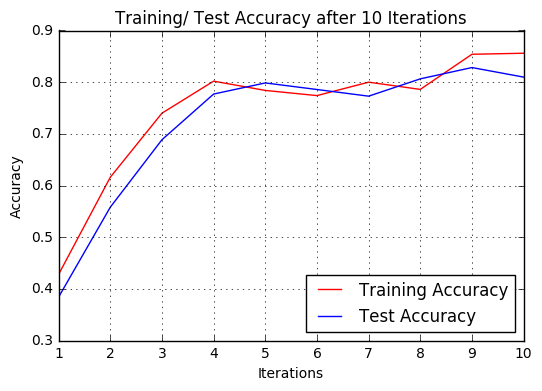

In [24]:
plt.title('Training/ Test Accuracy after 10 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.grid(True)
plt.plot(length10,train_acc10,color="red", label="Training Accuracy")
plt.plot(length10,test_acc10,color="blue", label="Test Accuracy")

plt.legend( loc='lower right')
plt.savefig("Accuracy_10a.png", bbox_inches='tight')
plt.show()

### Loss Plot

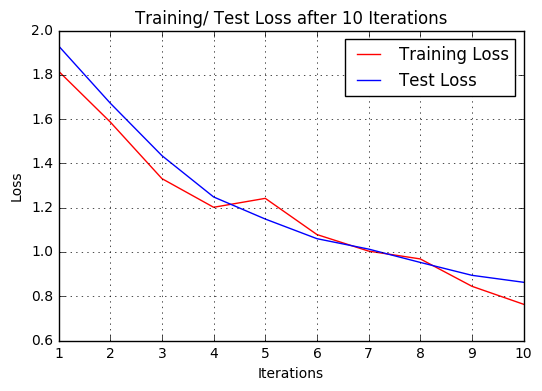

In [25]:
plt.title('Training/ Test Loss after 10 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.grid(True)
plt.plot(length10,train_loss10,color="red", label="Training Loss")
plt.plot(length10,test_loss10,color="blue", label="Test Loss")

plt.legend( loc='upper right')
plt.savefig("Loss_10a.png", bbox_inches='tight')
plt.show()

In [26]:
print_acc()

Training Accuracy: 80.0% 

Test Accuracy: 81.0% 



In [27]:
sess.run(tf.global_variables_initializer())

### 10,000 Iterations

In [28]:
[train_acc,test_acc,length,train_loss,test_loss] = optimize_train(iters = 10000,print_num = 50)
print_acc()

iteration:     1, 		 Train Accuracy: 49.4%

		 		 Test Accuracy: 45.2%

iteration:   201, 		 Train Accuracy: 89.0%

		 		 Test Accuracy: 90.8%

iteration:   401, 		 Train Accuracy: 90.0%

		 		 Test Accuracy: 91.5%

iteration:   601, 		 Train Accuracy: 91.4%

		 		 Test Accuracy: 91.8%

iteration:   801, 		 Train Accuracy: 91.6%

		 		 Test Accuracy: 91.9%

iteration:  1001, 		 Train Accuracy: 93.6%

		 		 Test Accuracy: 92.0%

iteration:  1201, 		 Train Accuracy: 92.4%

		 		 Test Accuracy: 92.2%

iteration:  1401, 		 Train Accuracy: 93.8%

		 		 Test Accuracy: 92.1%

iteration:  1601, 		 Train Accuracy: 92.4%

		 		 Test Accuracy: 92.3%

iteration:  1801, 		 Train Accuracy: 92.2%

		 		 Test Accuracy: 92.4%

iteration:  2001, 		 Train Accuracy: 92.0%

		 		 Test Accuracy: 92.3%

iteration:  2201, 		 Train Accuracy: 95.2%

		 		 Test Accuracy: 92.3%

iteration:  2401, 		 Train Accuracy: 91.6%

		 		 Test Accuracy: 92.3%

iteration:  2601, 		 Train Accuracy: 93.0%

		 		 Test Accuracy:

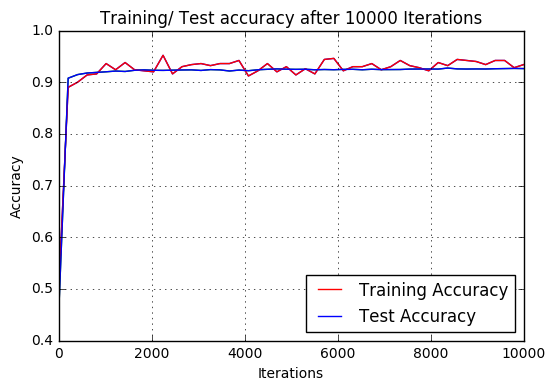

In [29]:
plt.title('Training/ Test accuracy after 10000 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.grid(True)
plt.plot(length,train_acc)
plt.plot(length,test_acc)
plt.plot(length,train_acc,color="red", label="Training Accuracy")
fig = plt.plot(length,test_acc,color="blue", label="Test Accuracy")


plt.legend( loc='lower right')
plt.savefig("Accuracy_10000a.png", bbox_inches='tight')
plt.show()


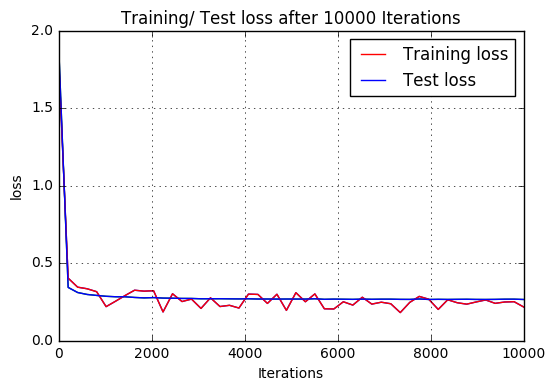

In [30]:
plt.title('Training/ Test loss after 10000 Iterations')
plt.xlabel('Iterations')
plt.ylabel('loss')

plt.grid(True)
plt.plot(length,train_loss)
plt.plot(length,test_loss)
plt.plot(length,train_loss,color="red", label="Training loss")
plt.plot(length,test_loss,color="blue", label="Test loss")
plt.legend( loc='upper right')
plt.savefig("Loss_10000a.png", bbox_inches='tight')
plt.show()

### Confusion matrix

[[ 961    0    1    3    0    7    5    2    1    0]
 [   0 1112    3    2    0    2    4    2   10    0]
 [   6    9  925   16   10    3   15    9   34    5]
 [   3    1   16  923    0   25    3   10   20    9]
 [   1    3    4    3  921    0   10    3    8   29]
 [  10    2    3   37   11  775   14    6   29    5]
 [  10    3    4    2    9   16  910    3    1    0]
 [   1    9   21    8    9    1    0  946    2   31]
 [   7   12    6   26    8   28   10    8  858   11]
 [  11    8    1    9   30    6    0   19    7  918]]


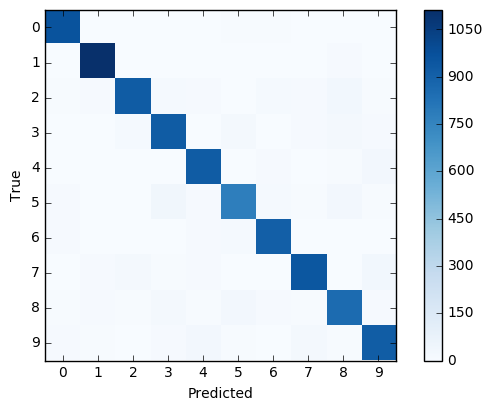

In [31]:
#defined the actual digits of labels again
y_true = data.test.labels
y_true_digit = np.argmax(y_true,axis = 1)

feed_dict_test = {x: data.test.images,
                           y_labels: data.test.labels}
# find the predicted labels
y_pred = sess.run(y_pred_digit, feed_dict = feed_dict_test)

# get the confusion matrix
conf_mat = confusion_matrix( y_true_digit,
                             y_pred)
print(conf_mat)
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(num_digits)
plt.xticks(tick_marks, range(num_digits))
plt.yticks(tick_marks, range(num_digits))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("CM_10000a.png", bbox_inches='tight')
plt.show()

In [56]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_digits)
    plt.xticks(tick_marks, range(num_digits))
    plt.yticks(tick_marks, range(num_digits))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #plt.tight_layout()

    width, height = cm.shape
    
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.savefig("CM_10000a.png", bbox_inches='tight')

    plt.show()

In [52]:
digits = np.array([np.linspace(0,9,10)])
print(conf_mat.shape)

(10, 10)


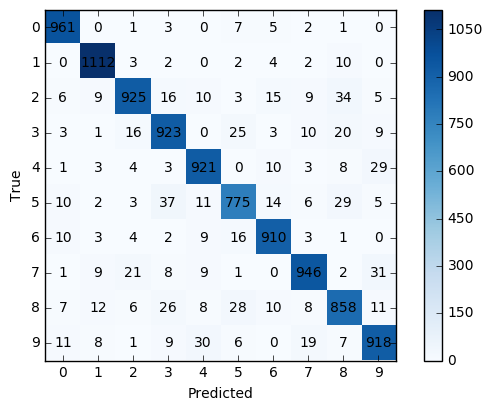

In [57]:
plot_confusion_matrix(conf_mat, digits)

In [31]:
saver.save(sess= sess, save_path = save_model)

'models/best_accuracy'

In [32]:
sess.close()

# Run the saved model notebook to check if the accuracy is the same as in the report.